In [1]:
'''
Playing around with some of the data that I've collected from WU.
How many snow days has Chapel Hill had in the past? How much did it 
snow? I isolate this data from the database using keywords in the 
weather conditions column to isolate those conditions that included
snow. Then I summarize with some graphs.
'''

import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

conn = sqlite3.connect('weather.db')
c = conn.cursor()
c.execute(''' SELECT * FROM historical_weather2 WHERE Key = 'KIGX' AND 
(Events = '\nSnow\n' OR Events = '\nFog\n\t,\nSnow\n')  ''')
dat = c.fetchall()
df = pd.DataFrame(dat)
cols = ['Time', 'Temp', 'Heat_Index', 'Dew_Point', 'Humidity', 
        'Pressure', 'Visibility', 'Wind_Dir', 'Wind_Speed', 'Gust_Speed', 
        'Precip', 'Events', 'Conditions', 'Date', 'Key', 
        'Hour', 'df_index']
df.columns = cols 

'''
Need to separate out the Day, Month, Year from the Date field
'''

#(1)This loop extracts the month from the Date field
df['Month']=np.nan
for i in range(len(df)):
    try:
        df.ix[i,"Month"] = int(df.ix[i,"Date"][5:7])
    except ValueError:
        df.ix[i,"Month"] = int(df.ix[i,"Date"][5:6])

#(2)This loop extracts the Day from the Date field
df['Day']=np.nan
for i in range(len(df)):
    if int(df.ix[i,'Date'][-2:]) < 0:
        df.ix[i,'Day'] = int(df.ix[i,'Date'][-1:])
    else:
        df.ix[i,'Day'] = int(df.ix[i,'Date'][-2:])

#(3)This loop extracts the year
df['Year'] = np.nan
for i in range(len(df)):
    df.ix[i,'Year'] = df.ix[i,'Date'][:4]    
    
'''
df_grp gets the snow label counts by Year, Month, Day: sums up the counts over
each of the times (hours).

This isn't great because I don't care about the snow by hour, I just want
to get the snow day count for each day
'''
grp = df.groupby(['Year', 'Month', 'Day', 'Conditions']).size()
df_grp = pd.DataFrame(grp.reset_index(name='Group Count'))

#sum up the number of days snow was in the forcast over the course of the day
df_grp['Day Count'] = 1
Daygrp = df_grp.ix[:,['Year', 'Day Count']].groupby(['Year']).sum()
df_Daygrp = pd.DataFrame(Daygrp.reset_index())

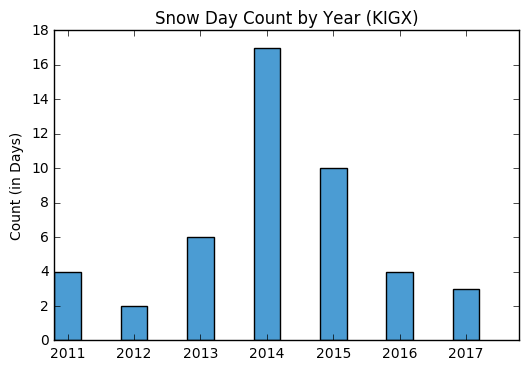

In [2]:
#Graph the results
x = df_Daygrp["Day Count"]
years = df_Daygrp["Year"]
N=len(df_Daygrp)
ind = np.arange(N)
width = 0.4
fig, ax = plt.subplots()
rects1 = ax.bar(ind, x, width, color=(0.29411,0.61176,0.82745))
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('2011','2012','2013','2014','2015','2016','2017'))
ax.set_ylabel('Count (in Days)')
ax.set_title('Snow Day Count by Year (KIGX)')

In [3]:
#Now I want to look at the precipitation of snow on the days snow was in the forecast

precip = df.groupby(['Year','Month','Day','Precip']).sum()
precip_df = pd.DataFrame(precip.reset_index())
precip_df = precip_df.ix[:,['Year','Month','Day','Precip']]

#The amounts recorded are cumulative amounts, so I'm taking the maximum over the day
precip_day = precip_df.groupby(['Year','Month','Day']).max()
precip_day_df = pd.DataFrame(precip_day.reset_index())

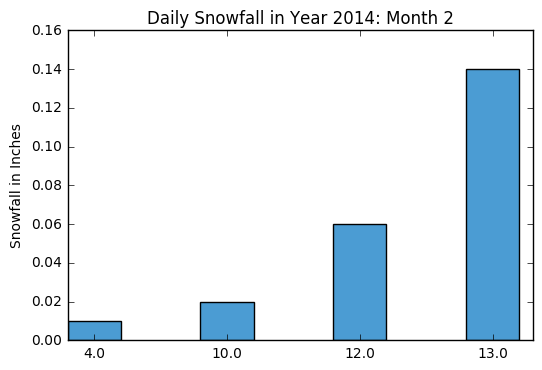

In [4]:
'''
Now I can graph how much it snowed in each day where snow was in the forecast

The year and month variables below change the graph to show the corresponding
dates. Some data is collected as a 0.0in record, in which case the graph
will be empty or not show any bars.
'''

year = '2014'
month = 2

# the results df is just the precipitation df above but with the 
# appropriate year and month extracted for graphing
results = precip_day_df.ix[precip_day_df['Year']==year,['Month','Day','Precip']]
results = results.ix[results['Month']==month,:]

x = results['Precip']
labels = results['Day']
N=len(results)
ind = np.arange(N)
width=.4
fix, ax = plt.subplots()
rects = ax.bar(ind, x, width, color=(0.29411,0.61176,0.82745))
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)
ax.set_ylabel('Snowfall in Inches')
ax.set_title('Daily Snowfall in Year ' + year + ': Month ' + str(month))